In [1]:
!pip install kagglehub[pandas-datasets]

In [2]:
import kagglehub
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Download the dataset
dataset_path = kagglehub.dataset_download("terencicp/e-commerce-dataset-by-olist-as-an-sqlite-database")
print("Dataset downloaded to:", dataset_path)

# Set path to olist.sqlite
file_path = f"{dataset_path}/olist.sqlite"

# Connect to SQLite database
conn = sqlite3.connect(file_path)

# Query to extract relevant data
query = """
SELECT 
    c.customer_id,
    c.customer_unique_id,
    c.customer_state,
    o.order_id,
    o.order_purchase_timestamp,
    oi.price,
    oi.freight_value,
    op.payment_value
FROM customers c
JOIN orders o ON c.customer_id = o.customer_id
JOIN order_items oi ON o.order_id = oi.order_id
JOIN order_payments op ON o.order_id = op.order_id
"""
df = pd.read_sql_query(query, conn)
conn.close()

# Display first 5 records
print("First 5 records:")
print(df.head())

/anaconda/envs/azureml_py38/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Dataset downloaded to: /home/azureuser/.cache/kagglehub/datasets/terencicp/e-commerce-dataset-by-olist-as-an-sqlite-database/versions/1
First 5 records:
                        customer_id                customer_unique_id  \
0  06b8999e2fba1a1fbc88172c00ba8bc7  861eff4711a542e4b93843c6dd7febb0   
1  18955e83d337fd6b2def6b18a428ac77  290c77bc529b7ac935b93aa66c333dc3   
2  4e7b3e00288586ebd08712fdd0374a03  060e732b5b29e8181a18229c7b0b2b5e   
3  b2b6027bc5c5109e529d4dc6358b12c3  259dac757896d24d7702b9acbbff3f3c   
4  4f2d8ab171c80ec8364f7c12e35b23ad  345ecd01c38d18a9036ed96c73b8d066   

  customer_state                          order_id order_purchase_timestamp  \
0             SP  00e7ee1b050b8499577073aeb2a297a1      2017-05-16 15:05:35   
1             SP  29150127e6685892b6eab3eec79f59c7      2018-01-12 20:48:24   
2             SP  b2059ed67ce144a36e2aa97d2c9e9ad2      2018-05-19 16:07:45   
3             SP  951670f92359f4fe4a63112aa7306eba      2018-03-13 16:06:38   
4            

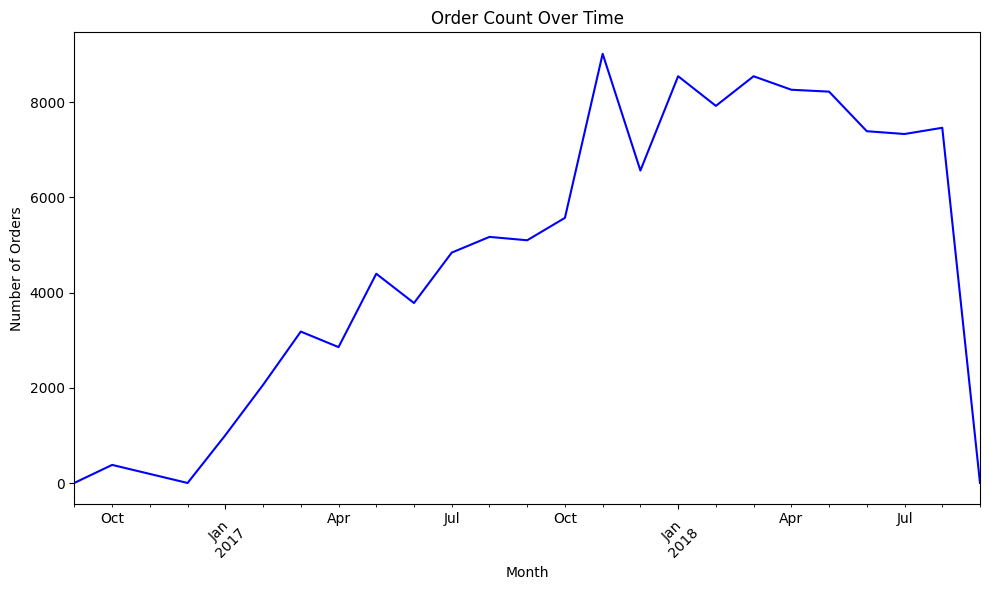

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Ensure order_purchase_timestamp is datetime
df['order_purchase_timestamp'] = pd.to_datetime(df['order_purchase_timestamp'])

# 1. Order Trends Over Time
df['order_month'] = df['order_purchase_timestamp'].dt.to_period('M')
order_counts = df.groupby('order_month').size()

plt.figure(figsize=(10, 6))
order_counts.plot(kind='line', color='blue')
plt.title('Order Count Over Time')
plt.xlabel('Month')
plt.ylabel('Number of Orders')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


/tmp/ipykernel_3600/3070300894.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=state_counts.index, y=state_counts.values, palette='viridis')


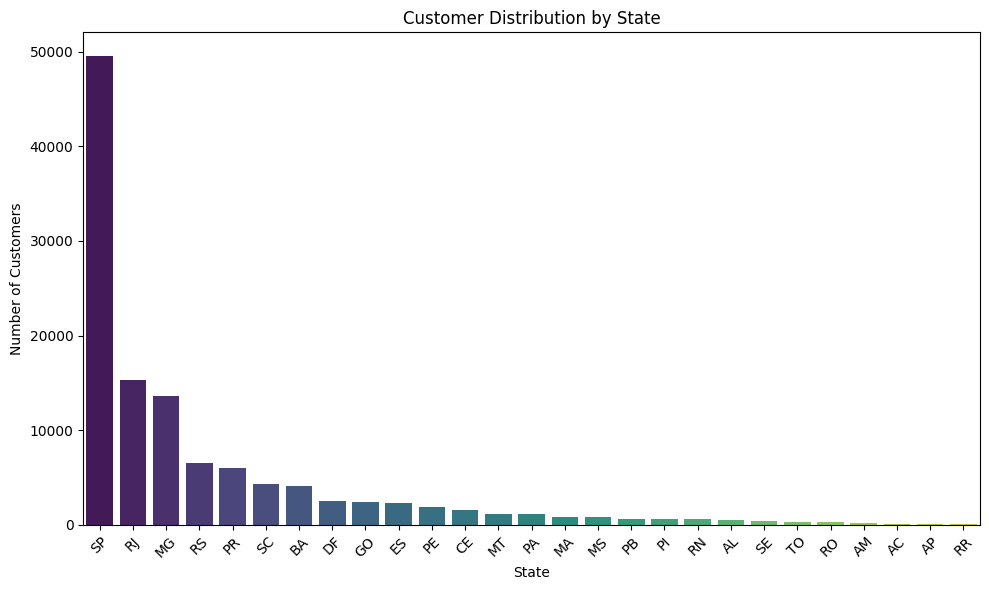

In [4]:
# 2. Customer Distribution by State
state_counts = df['customer_state'].value_counts()
plt.figure(figsize=(10, 6))
sns.barplot(x=state_counts.index, y=state_counts.values, palette='viridis')
plt.title('Customer Distribution by State')
plt.xlabel('State')
plt.ylabel('Number of Customers')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [5]:
# 3. Summary Statistics
print("Summary Statistics for Price, Freight Value, and Payment Value:")
print(df[['price', 'freight_value', 'payment_value']].describe())

Summary Statistics for Price, Freight Value, and Payment Value:
               price  freight_value  payment_value
count  117601.000000  117601.000000  117601.000000
mean      120.824783      20.045990     172.686752
std       184.479323      15.861315     267.592290
min         0.850000       0.000000       0.000000
25%        39.900000      13.080000      60.870000
50%        74.900000      16.290000     108.210000
75%       134.900000      21.190000     189.260000
max      6735.000000     409.680000   13664.080000


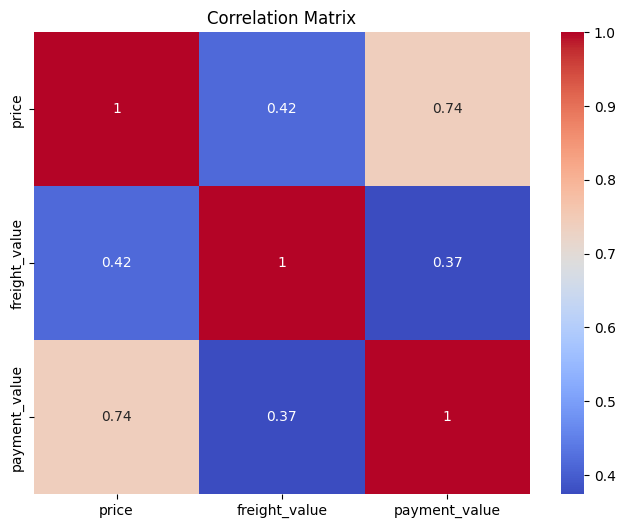

In [6]:
# 4. Correlation Analysis
plt.figure(figsize=(8, 6))
sns.heatmap(df[['price', 'freight_value', 'payment_value']].corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

In [7]:
# RFM calculation
current_date = df['order_purchase_timestamp'].max()
rfm = df.groupby('customer_unique_id').agg({
    'order_purchase_timestamp': lambda x: (current_date - x.max()).days,  # Recency
    'order_id': 'count',  # Frequency
    'payment_value': 'sum'  # Monetary
}).rename(columns={
    'order_purchase_timestamp': 'recency',
    'order_id': 'frequency',
    'payment_value': 'monetary'
})

# Add customer_state
rfm = rfm.merge(df[['customer_unique_id', 'customer_state']].drop_duplicates(), 
                on='customer_unique_id', how='left')

# Data quality checks
print("Missing values:", rfm.isnull().sum())
rfm = rfm.dropna()  # Drop missing values
print("Duplicates:", rfm['customer_unique_id'].duplicated().sum())

# Save to CSV
rfm.to_csv('rfm_data.csv', index=False)
print("RFM data saved to rfm_data.csv")

Missing values: customer_unique_id    0
recency               0
frequency             0
monetary              0
customer_state        0
dtype: int64
Duplicates: 38
RFM data saved to rfm_data.csv


In [8]:
import pandas as pd
rfm = pd.read_csv('rfm_data.csv')  # Adjust path
print(rfm.head())
print(rfm.columns)
print("Data types:", rfm.dtypes)
print("Missing values:", rfm.isnull().sum())

                 customer_unique_id  recency  frequency  monetary  \
0  0000366f3b9a7992bf8c76cfdf3221e2      115          1    141.90   
1  0000b849f77a49e4a4ce2b2a4ca5be3f      118          1     27.19   
2  0000f46a3911fa3c0805444483337064      541          1     86.22   
3  0000f6ccb0745a6a4b88665a16c9f078      325          1     43.62   
4  0004aac84e0df4da2b147fca70cf8255      292          1    196.89   

  customer_state  
0             SP  
1             SP  
2             SC  
3             PA  
4             SP  
Index(['customer_unique_id', 'recency', 'frequency', 'monetary',
       'customer_state'],
      dtype='object')
Data types: customer_unique_id     object
recency                 int64
frequency               int64
monetary              float64
customer_state         object
dtype: object
Missing values: customer_unique_id    0
recency               0
frequency             0
monetary              0
customer_state        0
dtype: int64


In [9]:
from azure.storage.blob import BlobServiceClient
import pandas as pd
import os

# Read connection string from text file
with open('connection_string.txt', 'r') as file:
    connection_string = file.read().strip()

# Define blob details
container_name = "azureml-blobstore-fe29cc4a-dba2-40b1-8277-8dd5fc899d45"
blob_name = "olist/rfm_encoded.csv"
local_file_name = "rfm_encoded.csv"

# Create a blob service client
blob_service_client = BlobServiceClient.from_connection_string(connection_string)
blob_client = blob_service_client.get_blob_client(container=container_name, blob=blob_name)

# Download the blob to a local file
print(f"Downloading {blob_name} to {local_file_name}...")
with open(local_file_name, "wb") as file:
    blob_data = blob_client.download_blob()
    file.write(blob_data.readall())
print("Download complete.")

# Read the CSV into a DataFrame
rfm_encoded = pd.read_csv(local_file_name)
print(rfm_encoded.head())
print("Shape:", rfm_encoded.shape)
print("Columns:", rfm_encoded.columns.tolist())

Download complete.
                 customer_unique_id  recency  frequency  monetary  state_AC  \
0  0000366f3b9a7992bf8c76cfdf3221e2      115          1    141.90         0   
1  0000b849f77a49e4a4ce2b2a4ca5be3f      118          1     27.19         0   
2  0000f46a3911fa3c0805444483337064      541          1     86.22         0   
3  0000f6ccb0745a6a4b88665a16c9f078      325          1     43.62         0   
4  0004aac84e0df4da2b147fca70cf8255      292          1    196.89         0   

   state_AL  state_AM  state_AP  state_BA  state_CE  ...  state_PR  state_RJ  \
0         0         0         0         0         0  ...         0         0   
1         0         0         0         0         0  ...         0         0   
2         0         0         0         0         0  ...         0         0   
3         0         0         0         0         0  ...         0         0   
4         0         0         0         0         0  ...         0         0   

   state_RN  state_RO  st

In [10]:
from azure.storage.blob import BlobServiceClient
import pandas as pd
import os

# Read connection string from text file
with open('connection_string.txt', 'r') as file:
    connection_string = file.read().strip()

# Define blob details
container_name = "azureml-blobstore-fe29cc4a-dba2-40b1-8277-8dd5fc899d45"
blob_name = "olist/clustered_rfm.csv"
local_file_name = "clustered_rfm.csv"

# Create a blob service client
blob_service_client = BlobServiceClient.from_connection_string(connection_string)
blob_client = blob_service_client.get_blob_client(container=container_name, blob=blob_name)

# Download the blob to a local file
print(f"Downloading {blob_name} to {local_file_name}...")
with open(local_file_name, "wb") as file:
    blob_data = blob_client.download_blob()
    file.write(blob_data.readall())
print("Download complete.")

# Read the CSV into a DataFrame
clustered_rfm = pd.read_csv(local_file_name)
print(clustered_rfm.head())
print("Shape:", clustered_rfm.shape)
print("Columns:", clustered_rfm.columns.tolist())

Download complete.
                 customer_unique_id   recency  frequency  monetary  state_AC  \
0  0000366f3b9a7992bf8c76cfdf3221e2  0.157967        0.0  0.001210         0   
1  0000b849f77a49e4a4ce2b2a4ca5be3f  0.162088        0.0  0.000161         0   
2  0000f46a3911fa3c0805444483337064  0.743132        0.0  0.000701         0   
3  0000f6ccb0745a6a4b88665a16c9f078  0.446429        0.0  0.000311         0   
4  0004aac84e0df4da2b147fca70cf8255  0.401099        0.0  0.001714         0   

   state_AL  state_AM  state_AP  state_BA  state_CE  ...  state_RS  state_SC  \
0         0         0         0         0         0  ...         0         0   
1         0         0         0         0         0  ...         0         0   
2         0         0         0         0         0  ...         0         1   
3         0         0         0         0         0  ...         0         0   
4         0         0         0         0         0  ...         0         0   

   state_SE  state_

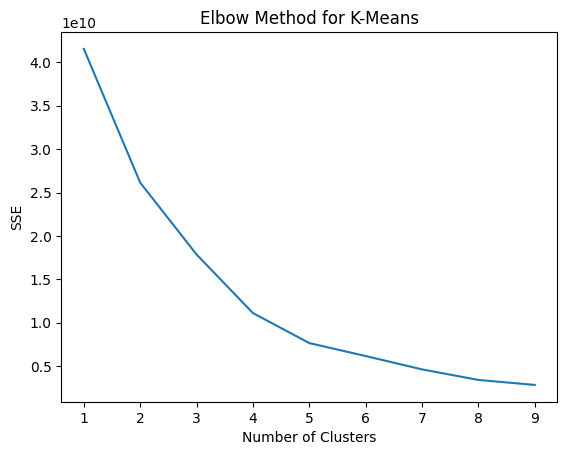

In [11]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

X = rfm[['recency', 'frequency', 'monetary']]
sse = []
for k in range(1, 10):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X)
    sse.append(kmeans.inertia_)
plt.plot(range(1, 10), sse)
plt.title('Elbow Method for K-Means')
plt.xlabel('Number of Clusters')
plt.ylabel('SSE')
plt.show()

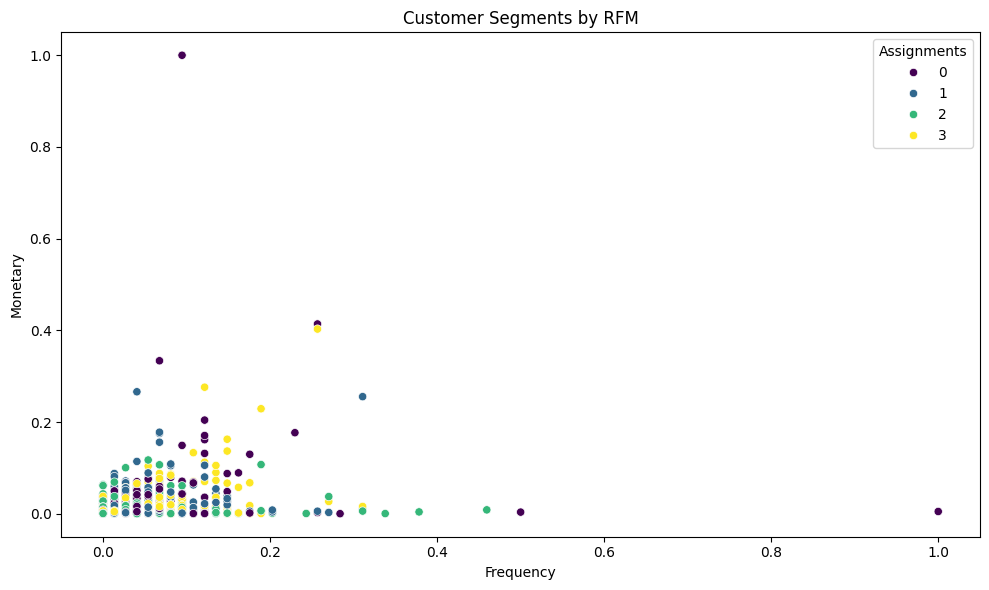

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns

# Load clustered data
clustered_data = pd.read_csv('clustered_rfm.csv')  # Adjust path
plt.figure(figsize=(10, 6))
sns.scatterplot(x='frequency', y='monetary', hue='Assignments', data=clustered_data, palette='viridis')
plt.title('Customer Segments by RFM')
plt.xlabel('Frequency')
plt.ylabel('Monetary')
plt.tight_layout()
plt.show()

In [14]:
from azure.storage.blob import BlobServiceClient
import pandas as pd
import os

# Read connection string from text file
with open('connection_string.txt', 'r') as file:
    connection_string = file.read().strip()

# Define blob details
container_name = "azureml-blobstore-fe29cc4a-dba2-40b1-8277-8dd5fc899d45"
blob_name = "olist/rf_predictions.csv"
local_file_name = "rf_predictions.csv"

# Create a blob service client
blob_service_client = BlobServiceClient.from_connection_string(connection_string)
blob_client = blob_service_client.get_blob_client(container=container_name, blob=blob_name)

# Download the blob to a local file
print(f"Downloading {blob_name} to {local_file_name}...")
with open(local_file_name, "wb") as file:
    blob_data = blob_client.download_blob()
    file.write(blob_data.readall())
print("Download complete.")

# Read the CSV into a DataFrame
rf_predictions = pd.read_csv(local_file_name)
print(clustered_rfm.head())
print("Shape:", clustered_rfm.shape)
print("Columns:", clustered_rfm.columns.tolist())

Download complete.
                 customer_unique_id   recency  frequency  monetary  state_AC  \
0  0000366f3b9a7992bf8c76cfdf3221e2  0.157967        0.0  0.001210         0   
1  0000b849f77a49e4a4ce2b2a4ca5be3f  0.162088        0.0  0.000161         0   
2  0000f46a3911fa3c0805444483337064  0.743132        0.0  0.000701         0   
3  0000f6ccb0745a6a4b88665a16c9f078  0.446429        0.0  0.000311         0   
4  0004aac84e0df4da2b147fca70cf8255  0.401099        0.0  0.001714         0   

   state_AL  state_AM  state_AP  state_BA  state_CE  ...  state_RS  state_SC  \
0         0         0         0         0         0  ...         0         0   
1         0         0         0         0         0  ...         0         0   
2         0         0         0         0         0  ...         0         1   
3         0         0         0         0         0  ...         0         0   
4         0         0         0         0         0  ...         0         0   

   state_SE  state_

In [21]:
# azureml-core of version 1.0.72 or higher is required
from azureml.core import Workspace, Dataset

subscription_id = 'dd8dd53a-04b9-4179-8411-335552874091'
resource_group = 'e-commerce'
workspace_name = 'E-commerce'

workspace = Workspace(subscription_id, resource_group, workspace_name)

dataset = Dataset.get_by_name(workspace, name='MD-Pipeline-Created-on-08-07-2025-Train_Model-Trained_model-dbe41850')
dataset.download(target_path='data', overwrite=False)

{'infer_column_types': 'False', 'activity': 'download'}
{'infer_column_types': 'False', 'activity': 'download', 'activityApp': 'FileDataset'}


['/mnt/batch/tasks/shared/LS_root/mounts/clusters/standard-e4ds-v4/code/Users/24m0008/data/_meta.yaml',
 '/mnt/batch/tasks/shared/LS_root/mounts/clusters/standard-e4ds-v4/code/Users/24m0008/data/data.ilearner',
 '/mnt/batch/tasks/shared/LS_root/mounts/clusters/standard-e4ds-v4/code/Users/24m0008/data/_samples.json',
 '/mnt/batch/tasks/shared/LS_root/mounts/clusters/standard-e4ds-v4/code/Users/24m0008/data/model_spec.yaml',
 '/mnt/batch/tasks/shared/LS_root/mounts/clusters/standard-e4ds-v4/code/Users/24m0008/data/_schema.json',
 '/mnt/batch/tasks/shared/LS_root/mounts/clusters/standard-e4ds-v4/code/Users/24m0008/data/score.py',
 '/mnt/batch/tasks/shared/LS_root/mounts/clusters/standard-e4ds-v4/code/Users/24m0008/data/conda_env.yaml']